# Using Clustering To Analyze Credit Card Data

* Motivation:

Unsupervised learning algorithms include several technique for grouping variables into categories that can be used to identify characteristics of the observations in the data. Clustering algorithms like k-means and hierarchical clustering are some of the most used and interpretable techniques out there. However, there are several other techniques that can be used and that rely mroe heavily on computer power and iterating proccesses than math. Two of those techniques are DBSCAN and MeanShift. In this notebook we will explore both techniques and compare the results. 


* Resources:
        
        *Dataset on Credit Card Transactions Made Available by the 
        *Aggregation of Variables to Create Ratios.
        *Clustering Analysis using DBSCAN and MeanShift
        
* Methods:
        
        *Creating Flags for Unusual Behaviors.
        *PCA dimension reduction.
        *Z-score for normalizing the variables.
        *Flooring and Capping.
        
* Objective:

By using the already modified dataset on Credit Card Transaction Data create clusters of data based on all the variables provided and provide some insights into the clusters to identify anomalies.

In [212]:
import pandas as pd
import os
import datetime
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import MeanShift, estimate_bandwidth
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import NearestNeighbors
from scipy import stats


os.chdir("/Users/luislosada/Columbia Drive/Anomaly Detection/Module 6")


In [2]:
#Load Data
data = pd.read_csv('complete_df.csv')
#Eliminate the spaces in column names for ease of handling and rename Merchant Category
data.columns = data.columns.str.replace(' ', '_')
data.rename(columns={"Merchant_Category_Code_(MCC)": 'Merchant_Category'},inplace=True)

In [3]:
data.insert(loc=data.columns.get_loc('month_num')+1,column='year',value=pd.DatetimeIndex(data['Posted_Date']).year)

### Data Aggregation

Although the dataset used has already some work done, we are going to be adding ratio amounts of the max and mean of the amount spent aggregated by Agency and Merchant Category. That aggregation will help us cluster observations and allow us to observe the observations that show some unusual behaviors.

In [4]:
avg_agency = data.groupby(['Agency_Name', 
                           'Merchant_Category']).agg({'Amount':'mean','Agency_Name':'count'}).rename(
    columns={'Amount':'Amount_Mean_by_Merch',
             'Agency_Name':'Num_Transactions_by_Merch'
           }).reset_index()
avg_agency.head()


,Agency_Name,Merchant_Category,Amount_Mean_by_Merch,Num_Transactions_by_Merch
0,ARDMORE HIGHER EDUCATION CENTER,BUSINESS SERVICES NOT ELSEWHERE CLASSIFIED,115.120000,1
1,ARDMORE HIGHER EDUCATION CENTER,CATALOG MERCHANTS,-53.344286,7
2,ARDMORE HIGHER EDUCATION CENTER,COMPUTER NETWORK/INFORMATION SERVICES,18.340000,1
3,ARDMORE HIGHER EDUCATION CENTER,DRUG STORES AND PHARMACIES,153.450000,1
4,ARDMORE HIGHER EDUCATION CENTER,"GROCERY STORES,AND SUPERMARKETS",74.525455,11


In [37]:
#Aggregate by Agency, Merchant Cat, and Year-Month
per_agency_category = data.groupby(['Agency_Name', 'Merchant_Category',
                                    'Year-Month'])['Amount'].agg(['mean','max','count']).rename(
    
    columns={'mean':'Amount_Mean_by_Month',
             'count':'Num_Transactions_by_Month',
             'max':'Amount_Max_by_Month'
           }).reset_index()

#Join the Avg Agency Dataset created before to the new aggregated dataset to get the mean and max amounts aggregated 
#by agency and Merchant

per_agency_category = pd.merge(per_agency_category,avg_agency,how='left', on=['Agency_Name','Merchant_Category'])

per_agency_category['max_amount_ratio'] = per_agency_category['Amount_Max_by_Month'] / per_agency_category['Amount_Mean_by_Merch']
per_agency_category['mean_amount_ratio'] = per_agency_category['Amount_Mean_by_Month'] / per_agency_category['Amount_Mean_by_Merch']
per_agency_category['mean_count_ratio'] = per_agency_category['Num_Transactions_by_Month'] / per_agency_category['Num_Transactions_by_Merch']

df_per_agency = per_agency_category[['Agency_Name','Merchant_Category','Year-Month','max_amount_ratio','mean_amount_ratio','mean_count_ratio']]
df_per_agency.head(10)

,Agency_Name,Merchant_Category,Year-Month,max_amount_ratio,mean_amount_ratio,mean_count_ratio
0,ARDMORE HIGHER EDUCATION CENTER,BUSINESS SERVICES NOT ELSEWHERE CLASSIFIED,201311,1.000000,1.000000,1.000000
1,ARDMORE HIGHER EDUCATION CENTER,CATALOG MERCHANTS,201307,11.368040,11.955357,0.285714
2,ARDMORE HIGHER EDUCATION CENTER,CATALOG MERCHANTS,201308,-12.542674,-12.542674,0.142857
3,ARDMORE HIGHER EDUCATION CENTER,CATALOG MERCHANTS,201309,6.271337,6.271337,0.142857
4,ARDMORE HIGHER EDUCATION CENTER,CATALOG MERCHANTS,201310,-6.271337,-6.271337,0.142857
5,ARDMORE HIGHER EDUCATION CENTER,CATALOG MERCHANTS,201311,-3.652687,-2.184020,0.285714
6,ARDMORE HIGHER EDUCATION CENTER,COMPUTER NETWORK/INFORMATION SERVICES,201310,1.000000,1.000000,1.000000
7,ARDMORE HIGHER EDUCATION CENTER,DRUG STORES AND PHARMACIES,201312,1.000000,1.000000,1.000000
8,ARDMORE HIGHER EDUCATION CENTER,"GROCERY STORES,AND SUPERMARKETS",201308,1.618373,0.974768,0.181818
9,ARDMORE HIGHER EDUCATION CENTER,"GROCERY STORES,AND SUPERMARKETS",201309,0.348203,0.348203,0.090909


Expanding the dataset from a long format to a wide format to get ratios per Agency and Category. This will allow us to grasp the data Year-Month variable and use it for our clustering models. 

In [6]:
def long_df(data,var):
    df = data[['Agency_Name','Merchant_Category','Year-Month',var]]
    name = str(var).split("_")[0]
    df.loc[:,'Year-Month'] =  [name+"_ratio_"+str(df.loc[i,'Year-Month']) for i in range(len(df['Year-Month']))]
    
    #From Long to Wide
    wide_max = df.pivot(columns='Year-Month', values=var)
    wide_max.fillna(0,inplace=True)
    wide_matrix = df.join(wide_max)
    wide_matrix.drop(columns=["Year-Month",var],inplace=True)
    return wide_matrix
max_per_agency = long_df(df_per_agency,'max_amount_ratio')
mean_per_agency = long_df(df_per_agency,'mean_amount_ratio')

mean_per_agency.head(10)

/Library/Python/3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,Agency_Name,Merchant_Category,mean_ratio_201307,mean_ratio_201308,mean_ratio_201309,mean_ratio_201310,mean_ratio_201311,mean_ratio_201312,mean_ratio_201401,mean_ratio_201402,mean_ratio_201403,mean_ratio_201404,mean_ratio_201405,mean_ratio_201406
0,ARDMORE HIGHER EDUCATION CENTER,BUSINESS SERVICES NOT ELSEWHERE CLASSIFIED,0.000000,0.000000,0.000000,0.000000,1.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ARDMORE HIGHER EDUCATION CENTER,CATALOG MERCHANTS,11.955357,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ARDMORE HIGHER EDUCATION CENTER,CATALOG MERCHANTS,0.000000,-12.542674,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ARDMORE HIGHER EDUCATION CENTER,CATALOG MERCHANTS,0.000000,0.000000,6.271337,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ARDMORE HIGHER EDUCATION CENTER,CATALOG MERCHANTS,0.000000,0.000000,0.000000,-6.271337,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,ARDMORE HIGHER EDUCATION CENTER,CATALOG MERCHANTS,0.000000,0.000000,0.000000,0.000000,-2.18402,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,ARDMORE HIGHER EDUCATION CENTER,COMPUTER NETWORK/INFORMATION SERVICES,0.000000,0.000000,0.000000,1.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,ARDMORE HIGHER EDUCATION CENTER,DRUG STORES AND PHARMACIES,0.000000,0.000000,0.000000,0.000000,0.00000,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8,ARDMORE HIGHER EDUCATION CENTER,"GROCERY STORES,AND SUPERMARKETS",0.000000,0.974768,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,ARDMORE HIGHER EDUCATION CENTER,"GROCERY STORES,AND SUPERMARKETS",0.000000,0.000000,0.348203,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
#Cleanning data by replacing Inf for max/min values.

df_per_agency['mean_amount_ratio'] = df_per_agency.mean_amount_ratio.replace([np.inf],0.123456789)
df_per_agency['mean_amount_ratio'] = df_per_agency.mean_amount_ratio.replace([-np.inf],-0.123456789)
df_per_agency['mean_amount_ratio'] = df_per_agency.mean_amount_ratio.replace([0.123456789], df_per_agency.mean_amount_ratio.max())
df_per_agency['mean_amount_ratio'] = df_per_agency.mean_amount_ratio.replace([-0.123456789], df_per_agency.mean_amount_ratio.min())
df_per_agency['mean_amount_ratio'] = df_per_agency.mean_amount_ratio.replace([np.nan],0)

df_per_agency['max_amount_ratio'] = df_per_agency.max_amount_ratio.replace([np.inf],0.123456789)
df_per_agency['max_amount_ratio'] = df_per_agency.max_amount_ratio.replace([-np.inf],-0.123456789)
df_per_agency['max_amount_ratio'] = df_per_agency.max_amount_ratio.replace([0.123456789], df_per_agency.max_amount_ratio.max())
df_per_agency['max_amount_ratio'] = df_per_agency.max_amount_ratio.replace([-0.123456789], df_per_agency.max_amount_ratio.min())
df_per_agency['max_amount_ratio'] = df_per_agency.max_amount_ratio.replace([np.nan],0)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A 

In [40]:
#Obtained Results
df_per_agency['mean_amount_ratio'].describe()


count    3.988600e+04
mean    -2.570013e+12
std      1.299836e+14
min     -5.477503e+15
25%      5.363626e-01
50%      9.404923e-01
75%      1.241805e+00
max      7.825004e+14
Name: mean_amount_ratio, dtype: float64

It seems that there are very big outliers in both tails of the data (positive and negative) so lets take a look at that.

In [9]:
#Lets print observations with very small ratios (negative values)
very_small_ratio = df_per_agency.nsmallest(5000, 'mean_amount_ratio')[['Agency_Name',"Merchant_Category"]].reset_index(drop=True)

ll=[]
for i in range(len(very_small_ratio)):
    ind = np.array(np.where((data.Agency_Name == very_small_ratio.loc[1,'Agency_Name']) & (data.Merchant_Category == very_small_ratio.loc[1,'Merchant_Category']))).tolist()[0]
    ll.append(ind)

#Lets find out who are these users
inde = [item for sublist in ll for item in sublist]

suspicious = data.iloc[inde,:]
suspicious.head(10)


,User_ID,Year-Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,...,"amount.equalSize(25,41.4]","amount.equalSize(41.4,70]","amount.equalSize(70,105]","amount.equalSize(105,168]","amount.equalSize(168,270]","amount.equalSize(270,441]","amount.equalSize(441,820]","amount.equalSize(820,1.75e+06]",flag_amount_bin,merc_class
70431,uid_1908,201310,4000,DEPARTMENT OF AGRICULTURE,Keener,K,ROOM CHARGES,320.42,OMNI DALLAS CON CTR HT,2013-10-28T16:00:00Z,...,0,0,0,0,0,1,0,0,0,Travel/Media
71442,uid_1908,201312,4000,DEPARTMENT OF AGRICULTURE,Keener,K,ROOM CHARGES,-320.42,OMNI DALLAS CON CTR HT,2013-11-03T16:00:00Z,...,0,0,0,0,0,0,0,0,0,Travel/Media
70431,uid_1908,201310,4000,DEPARTMENT OF AGRICULTURE,Keener,K,ROOM CHARGES,320.42,OMNI DALLAS CON CTR HT,2013-10-28T16:00:00Z,...,0,0,0,0,0,1,0,0,0,Travel/Media
71442,uid_1908,201312,4000,DEPARTMENT OF AGRICULTURE,Keener,K,ROOM CHARGES,-320.42,OMNI DALLAS CON CTR HT,2013-11-03T16:00:00Z,...,0,0,0,0,0,0,0,0,0,Travel/Media
70431,uid_1908,201310,4000,DEPARTMENT OF AGRICULTURE,Keener,K,ROOM CHARGES,320.42,OMNI DALLAS CON CTR HT,2013-10-28T16:00:00Z,...,0,0,0,0,0,1,0,0,0,Travel/Media
71442,uid_1908,201312,4000,DEPARTMENT OF AGRICULTURE,Keener,K,ROOM CHARGES,-320.42,OMNI DALLAS CON CTR HT,2013-11-03T16:00:00Z,...,0,0,0,0,0,0,0,0,0,Travel/Media
70431,uid_1908,201310,4000,DEPARTMENT OF AGRICULTURE,Keener,K,ROOM CHARGES,320.42,OMNI DALLAS CON CTR HT,2013-10-28T16:00:00Z,...,0,0,0,0,0,1,0,0,0,Travel/Media
71442,uid_1908,201312,4000,DEPARTMENT OF AGRICULTURE,Keener,K,ROOM CHARGES,-320.42,OMNI DALLAS CON CTR HT,2013-11-03T16:00:00Z,...,0,0,0,0,0,0,0,0,0,Travel/Media
70431,uid_1908,201310,4000,DEPARTMENT OF AGRICULTURE,Keener,K,ROOM CHARGES,320.42,OMNI DALLAS CON CTR HT,2013-10-28T16:00:00Z,...,0,0,0,0,0,1,0,0,0,Travel/Media
71442,uid_1908,201312,4000,DEPARTMENT OF AGRICULTURE,Keener,K,ROOM CHARGES,-320.42,OMNI DALLAS CON CTR HT,2013-11-03T16:00:00Z,...,0,0,0,0,0,0,0,0,0,Travel/Media


## Flagging Suspicious Behavior
Wow Keener K seem to have a very unusual and suspicious behavior. In a span of a week the same transaction is repeated
and the money got returned at some point afterwards.
- Lets try flagging these instances. Lets calculate total transactions per user and the unique amounts. If the Ratio Count of transaction to unique amounts is very low we will flag it. 
- These observations also seem to have a lot values returned; lets flag these instances. Lets calculate positive and negative values and calculate the unique combinations of positive and negative amounts. If the ratio of positive to negative amounts is close or over 1 then we flag it.


In [12]:
#Ratio of Unique Transactions to Transactions
data['ratio_of_transaction'] = ''
for id in ids:
    ind = np.array(np.where(data.User_ID == id)).tolist()[0]
    n = data[data.User_ID == id].count()[0]
    uni_amount = data.Amount[data.User_ID == id].abs().drop_duplicates().count()
    prop = uni_amount/n
    data.loc[ind,'ratio_of_transaction'] = prop

In [11]:
#Creating the Postive and Negative Column.
pos_neg = ['positive' if x>=0 else 'negative' for x in data.Amount]
data.insert(loc = data.columns.get_loc('Amount')+1,column='Positive_Negative',value=pos_neg)
ids = data.User_ID.unique()


In [13]:
#Quick Look at the variable created.
data.ratio_of_transaction = pd.to_numeric(data.ratio_of_transaction)
data.ratio_of_transaction.describe()


count    442458.000000
mean          0.789926
std           0.215617
min           0.016393
25%           0.734694
50%           0.868020
75%           0.936364
max           1.000000
Name: ratio_of_transaction, dtype: float64

In [14]:
#Ratio of Positive to Negative per User
data['Flag_Ratio_of_Unique_Transactions'] = [1 if data.ratio_of_transaction[i]<=0.50 else 0 for i in range(len(data.ratio_of_transaction))]
data['Flag_Ratio_of_Unique_Transactions'].value_counts()

0    385793
1     56665
Name: Flag_Ratio_of_Unique_Transactions, dtype: int64

In [15]:
prop_count = data.groupby('User_ID')['Positive_Negative'].value_counts(normalize=True)
prop_count = pd.DataFrame(prop_count).rename(columns={'Positive_Negative':'Prop'}).reset_index()                                                                       
print(prop_count[prop_count.Positive_Negative == 'negative'].describe())
print(prop_count[prop_count.Positive_Negative == 'positive'].describe())


              Prop
count  3198.000000
mean      0.064976
std       0.087038
min       0.001479
25%       0.022727
50%       0.040541
75%       0.074074
max       1.000000
              Prop
count  5561.000000
mean      0.964432
std       0.060995
min       0.333333
25%       0.953488
50%       0.984496
75%       1.000000
max       1.000000


In [16]:
out = []
for i in range(len(prop_count)-1):
    if prop_count.Positive_Negative[i] == 'negative' and prop_count.Prop[i]>0.30:
        out.append(prop_count.User_ID[i])
    elif prop_count.Positive_Negative[i] == 'positive' and prop_count.Positive_Negative[i+1] == 'negative' and prop_count.Prop[i]< prop_count.Prop[i+1]:
        out.append(prop_count.User_ID[i])
    elif prop_count.Positive_Negative[i] == 'positive' and prop_count.Prop[i] <.60 and prop_count.Prop[i] >.30:
        out.append(prop_count.User_ID[i])
out = list(set(out))
out


['uid_4690',
 'uid_5164',
 'uid_5370',
 'uid_4033',
 'uid_5383',
 'uid_5464',
 'uid_4986',
 'uid_2324',
 'uid_4264',
 'uid_4588',
 'uid_5326',
 'uid_4324',
 'uid_3944',
 'uid_5165',
 'uid_4683',
 'uid_1785',
 'uid_1985',
 'uid_5003',
 'uid_373',
 'uid_4042',
 'uid_2331',
 'uid_4318',
 'uid_684',
 'uid_3204',
 'uid_1613',
 'uid_5438',
 'uid_815',
 'uid_824',
 'uid_1831',
 'uid_1646',
 'uid_2276',
 'uid_2329',
 'uid_3046',
 'uid_2552',
 'uid_4055',
 'uid_1107',
 'uid_4020',
 'uid_1624',
 'uid_1118',
 'uid_4916',
 'uid_1530',
 'uid_4316',
 'uid_3950',
 'uid_5234',
 'uid_5546',
 'uid_1077',
 'uid_1550',
 'uid_1970',
 'uid_2202',
 'uid_3874',
 'uid_2522',
 'uid_3368',
 'uid_5491',
 'uid_5301',
 'uid_2313',
 'uid_5515',
 'uid_1687',
 'uid_1442',
 'uid_2540',
 'uid_3114',
 'uid_652',
 'uid_4080',
 'uid_4273',
 'uid_1557',
 'uid_1406',
 'uid_5023',
 'uid_4960',
 'uid_4349',
 'uid_2322',
 'uid_4913']

In [17]:
data['Flag_Pos_Neg'] = 0
xl = [np.array(np.where(data.User_ID  == out[i])).tolist()[0] for i in range(len(out))]
xl = [item for sublist in xl for item in sublist]
data.loc[xl,'Flag_Pos_Neg'] = 1
data.Flag_Pos_Neg.value_counts()


0    442090
1       368
Name: Flag_Pos_Neg, dtype: int64

## Grouping Flags per Agency
If the objective is finding out what are the agencies with outlier behavior then lets use the flags we've created and aggregate them by Agency. We will use this dataset for our clustering methods too. It should be able to cluster Agencies with lots of red flags vs those with little or no red falgs.

Side Note: This dataset will be normalized as flag variables contain boolean values.


In [18]:
flag_aggregated = data.groupby(['Agency_Name', 
                           'Merchant_Category','Year-Month']).agg({'Flag_Pos_Neg':'mean',
                                                                   'Flag_Ratio_of_Unique_Transactions':'mean',
                                                                   'flag_amount_bin':'mean',
                                                                   'flag_week_amount':'mean',
                                                                   'flag_month_amount':'mean'}).rename(
    columns={'Flag_Pos_Neg':'Flag_Pos_Neg_Mean',
             'Flag_Ratio_of_Unique_Transactions':'Flag_Ratio_of_Unique_Transactions_Mean'
           }).reset_index()
flag_aggregated[flag_aggregated.flag_amount_bin >0]


,Agency_Name,Merchant_Category,Year-Month,Flag_Pos_Neg_Mean,Flag_Ratio_of_Unique_Transactions_Mean,flag_amount_bin,flag_week_amount,flag_month_amount
26180,OKLAHOMA STATE UNIVERSITY,ADVERTISING SERVICES,201307,0.000000,0.045455,0.136364,0.295455,0.113636
26192,OKLAHOMA STATE UNIVERSITY,AGRICULTURAL COOPERATIVES,201307,0.000000,0.000000,0.200000,0.200000,0.100000
26215,OKLAHOMA STATE UNIVERSITY,AIRLINES AND AIR CARRIERS,201307,0.000000,0.000000,0.125000,0.000000,0.187500
26228,OKLAHOMA STATE UNIVERSITY,AIRTRAN AIRWAYS,201307,0.000000,0.000000,1.000000,0.000000,0.000000
26239,OKLAHOMA STATE UNIVERSITY,AMERICAN AIRLINES,201307,0.000000,0.540541,0.108108,0.540541,0.135135
26270,OKLAHOMA STATE UNIVERSITY,ANTIQUE SHOPS,201307,0.000000,0.000000,1.000000,0.000000,0.000000
26295,OKLAHOMA STATE UNIVERSITY,ARIA,201307,0.000000,0.000000,0.250000,0.000000,0.000000
26296,OKLAHOMA STATE UNIVERSITY,ART DEALERS AND GALLERIES,201307,0.000000,0.000000,0.714286,0.000000,0.000000
26320,OKLAHOMA STATE UNIVERSITY,AUTOMATED FUEL DISPENSER,201307,0.000000,0.000000,0.111111,0.111111,0.000000
26350,OKLAHOMA STATE UNIVERSITY,AUTOMOTIVE PARTS AND ACCESSORIES STORES,201307,0.000000,0.009756,0.131707,0.078049,0.024390


## Clustering with DBSCAN and MeanShift

Using the 3 datasets created lets build clusters using the DBSCAN and MeanShift algorithms for each dataset. The results will then be compared and the outliers for each clustering method will be picked.

##### Flooring and Capping
Before we start thou, it seems like the mean and max ratio have some huge outliers. This will affect our clustering algorithms. Lets fix this by using capping and flooring methods to group these outliers together.

In [46]:
#Before Capping, HUGE outliers at the min and max values
print(df_per_agency['mean_amount_ratio'].describe())
print(df_per_agency['max_amount_ratio'].describe())

count    3.988600e+04
mean    -2.570013e+12
std      1.299836e+14
min     -5.477503e+15
25%      5.363626e-01
50%      9.404923e-01
75%      1.241805e+00
max      7.825004e+14
Name: mean_amount_ratio, dtype: float64
count    39886.000000
mean         2.669659
std          3.923309
min         -0.006756
25%          0.782994
50%          1.337015
75%          2.832010
max         25.705410
Name: max_amount_ratio, dtype: float64


In [45]:
percentiles = df_per_agency["max_amount_ratio"].quantile([0.01,0.99]).values
df_per_agency.loc[df_per_agency['max_amount_ratio'] <= percentiles[0],'max_amount_ratio'] = percentiles[0]
df_per_agency.loc[df_per_agency['max_amount_ratio'] >= percentiles[1],'max_amount_ratio'] = percentiles[1]

print(df_per_agency['max_amount_ratio'].describe())

count    39886.000000
mean         2.669659
std          3.923309
min         -0.006756
25%          0.782994
50%          1.337015
75%          2.832010
max         25.705410
Name: max_amount_ratio, dtype: float64


In [47]:
percentiles = df_per_agency["mean_amount_ratio"].quantile([0.01,0.99]).values
df_per_agency.loc[df_per_agency['mean_amount_ratio'] <= percentiles[0],'mean_amount_ratio'] = percentiles[0]
df_per_agency.loc[df_per_agency['mean_amount_ratio'] >= percentiles[1],'mean_amount_ratio'] = percentiles[1]

print(df_per_agency['mean_amount_ratio'].describe())

count    39886.000000
mean         1.015888
std          0.762939
min         -0.105672
25%          0.536363
50%          0.940492
75%          1.241805
max          4.423222
Name: mean_amount_ratio, dtype: float64


After capping and flooring we can see that the range falls into way more manageable values and the mean grows closer to 0 (where most of the observations lie on). This will allow for a better representation of our set by the clustering algos.

## DBSCAN
After all the variables are created and ready lets test out a DBSCAN clustering technique to identify the outliers.
We will test out the clusters for all three datasets created: the max_per_agency, the mean_per_agency and the flag_aggregated and compare the results.


In [86]:
for_cluster = df_per_agency.iloc[:,3:]
#the scaler function from sklearn does the z-score calculation automatically for each observation.
def z_score(df):
    for col in df:
        col_zscore = col + '_zscore'
        df[col_zscore] = (df[col] - df[col].mean())/df[col].std(ddof=0)
    return df

scaled_df = z_score(for_cluster)
scaled_df.describe()

,max_amount_ratio,mean_amount_ratio,mean_count_ratio,clusters,max_amount_ratio_zscore,mean_amount_ratio_zscore,mean_count_ratio_zscore,clusters_zscore
count,39886.000000,39886.000000,39886.000000,39886.000000,3.988600e+04,3.988600e+04,3.988600e+04,3.988600e+04
mean,2.669659,1.015888,0.211227,-0.011834,-7.410765e-17,1.854473e-16,-6.128133e-17,-6.591306e-18
std,3.923309,0.762939,0.243565,0.217938,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00
min,-0.006756,-0.105672,0.002833,-1.000000,-6.821918e-01,-1.470071e+00,-8.556103e-01,-4.534222e+00
25%,0.782994,0.536363,0.073529,0.000000,-4.808922e-01,-6.285315e-01,-5.653493e-01,5.429930e-02
50%,1.337015,0.940492,0.111697,0.000000,-3.396779e-01,-9.882347e-02,-4.086414e-01,5.429930e-02
75%,2.832010,1.241805,0.235294,0.000000,4.138159e-02,2.961184e-01,9.881313e-02,5.429930e-02
max,25.705410,4.423222,1.000000,5.000000,5.871584e+00,4.466121e+00,3.238490e+00,2.299691e+01


In order to select the ideal epsilon value lets run a nearest neighbors algorithm and measure the distance between the neighbors. The ideal epsilon amount will be where the elbow of the data is located.

*Method extracted from this [article]('https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc').

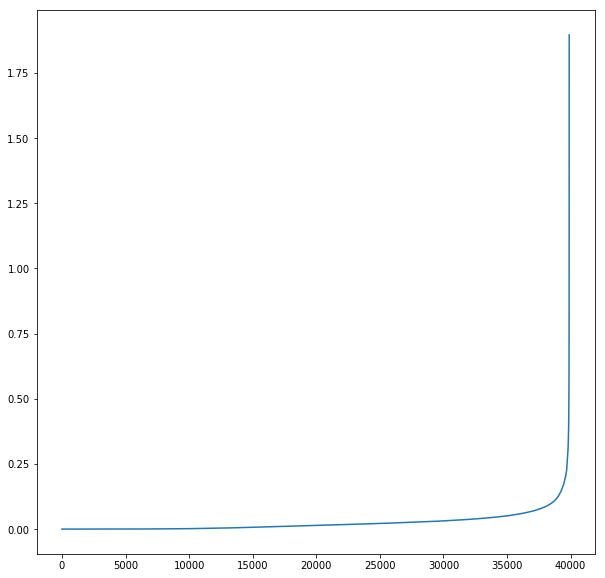

In [87]:
#Subset for Only the Scaled Data
scaled_df = scaled_df.iloc[:,3:]
neigh = NearestNeighbors(n_neighbors=2) 
nbrs = neigh.fit(scaled_df)
distances, indices = nbrs.kneighbors(scaled_df)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(10,10))
plt.plot(distances)

The ideal epsilon for this dataset seems to be 0.20, lets run our DBSCAN with that and see how it looks.

In [88]:
#Creating the Clusters using DBSCAN
dbsc = DBSCAN(eps = .20, min_samples = 30)
clusters = dbsc.fit_predict(scaled_df)

labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True


##### T-SNE
There are numerous techniques and articles around dimension reduction but for data visualizations T-SNE is amongst the best as it is able to unravel highly dimensional data into a 2-D Diagram wihtout decomposing the distance between observations as much as other techniques. Therfore, I'll use T-SNE to reduce the scaled_df to two variables. I'll also use serveral perplexity parameters to get the ideal value for the visualization of this dataset. Higher perpelxity causes observations to gravitate more towards a center so the data is less spread out.

In [60]:
all_perpex= {}
per = [2,50,100]
for i in range(len(per)):
    tsne_model = TSNE(perplexity=per[i], n_components=2, init='pca',metric='cosine', n_iter=2000)
    all_perpex[per[i]] = pd.DataFrame(tsne_model.fit_transform(scaled_df))


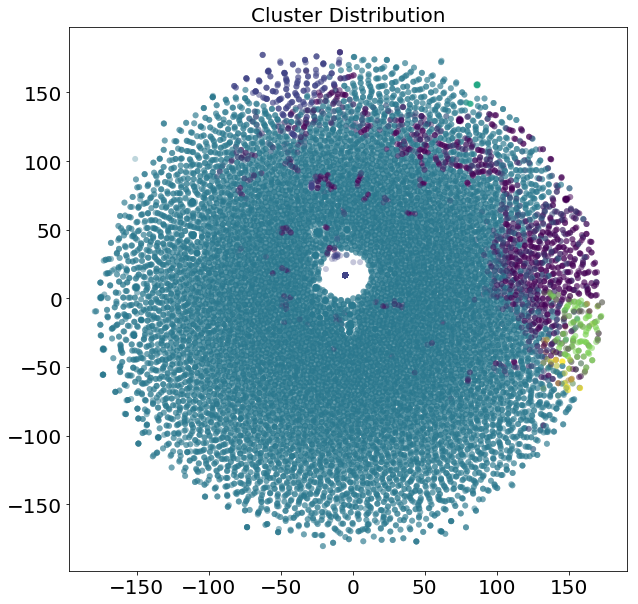

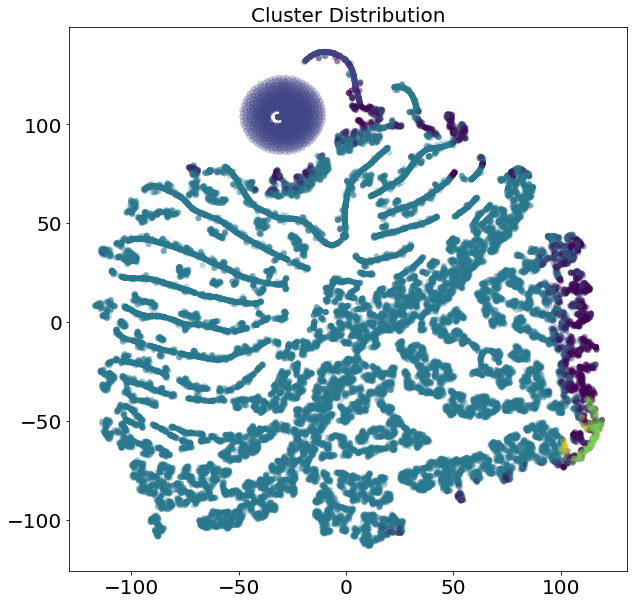

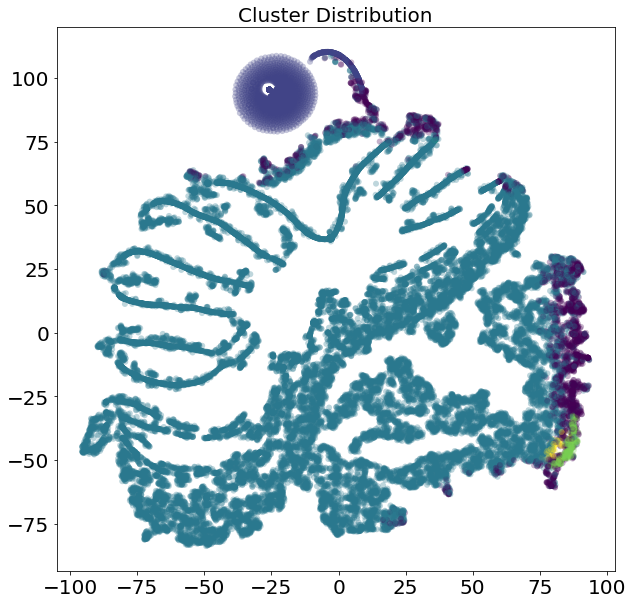

In [148]:
for p in range(len(per)):
    for_plot = pd.DataFrame({"X":all_perpex[per[p]].iloc[:,0],
                             "Y":all_perpex[per[p]].iloc[:,1],
                             "Cluster":clusters
        
    })
    
    plt.figure(figsize=(10,10))
    plt.scatter(for_plot['X'],for_plot['Y'],c=for_plot['Cluster'],label = 'no_lengend',alpha=0.3,edgecolors = 'none')
    plt.title("Cluster Distribution", fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()
    

In [89]:
df_per_agency['clusters'] = clusters
df_per_agency['clusters'].value_counts()


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


 1    34531
-1     2594
 0     2428
 3      246
 4       65
 2       22
Name: clusters, dtype: int64

The data shows that there are 5 clusters. Clusters 0 and 1 seem to grasp most of the data while the others seem to produce smaller clusters. Cluster 2 is of special interest and cluster -1 is for orphan data, meaning observations that could not be aggregated to any cluster so these two are our suspects.

Now lets see what happens when we try DBSCAN on the flag_aggregated data.

In [145]:
clusters2 = dbsc.fit_predict(flag_aggregated.iloc[:,3:])

labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True


In [156]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(flag_aggregated.iloc[:,3:])
principalDf = pd.DataFrame(data = principalComponents
            , columns = ['principal component 1', 'principal component 2','principal component 3'])
principalDf.insert(loc=3,column='cluster',value = clusters2)

principalDf.head(10)


,principal component 1,principal component 2,principal component 3,cluster
0,-0.198768,-0.005672,-0.017091,0
1,0.864538,-0.700410,0.591742,0
2,-0.198768,-0.005672,-0.017091,0
3,-0.198768,-0.005672,-0.017091,0
4,-0.198768,-0.005672,-0.017091,0
5,-0.198768,-0.005672,-0.017091,0
6,-0.198768,-0.005672,-0.017091,0
7,-0.198768,-0.005672,-0.017091,0
8,-0.070174,-0.105768,0.449154,0
9,-0.198768,-0.005672,-0.017091,0


No handles with labels found to put in legend.


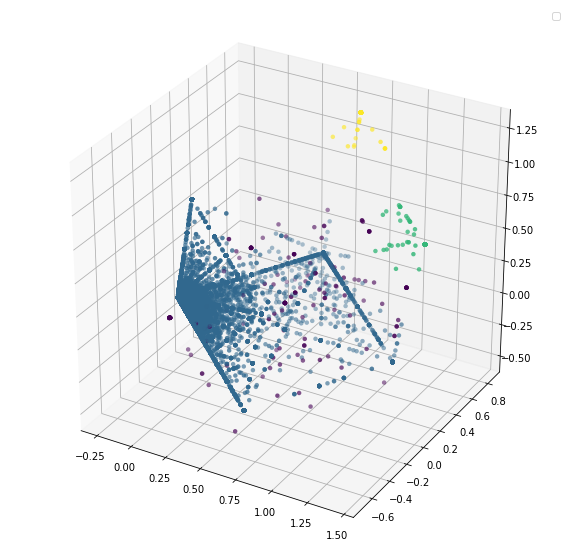

In [177]:
x=principalDf.iloc[:,0]
y=principalDf.iloc[:,1]
z=principalDf.iloc[:,2]
ax = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter3D(x, y, z, c=principalDf.iloc[:,3],edgecolors='none')
ax.legend()


In [147]:
flag_aggregated['cluster_DB'] = clusters2
flag_aggregated['cluster_DB'].value_counts()


 0    39528
-1      182
 1       98
 2       78
Name: cluster_DB, dtype: int64

So this flag aggregated dataset produces even better results and the 3D Visualization helps us see what's happening: 
- Most points are on the 0 cluster (blue points) and are clustered together
- A second set of orphan points (purple points) are scattered all over the place because they couldn't find a cluster to attach to.
- The other 2 clusters show us two sets of clusters that seem to share similar charactericts. Lets explotre these clusters further.

In [184]:
flag_aggregated[flag_aggregated['cluster_DB'] == 1].head()

,Agency_Name,Merchant_Category,Year-Month,Amount_Mean_by_Month,Amount_Max_by_Month,Num_Transactions_by_Month,Amount_Mean_by_Merch,Num_Transactions_by_Merch,max_amount_ratio,mean_amount_ratio,mean_count_ratio
501,BD. OF MED. LICENSURE & SUPV.,BUSINESS SERVICES NOT ELSEWHERE CLASSIFIED,201311,113.05,113.05,1,248.100741,27,0.455662,0.455662,0.037037
507,BD. OF MED. LICENSURE & SUPV.,BUSINESS SERVICES NOT ELSEWHERE CLASSIFIED,201406,257.17,434.23,2,248.100741,27,1.750216,1.036555,0.074074
518,BD. OF MED. LICENSURE & SUPV.,CATERERS,201406,375.00,375.00,1,416.803333,6,0.899705,0.899705,0.166667
521,BD. OF MED. LICENSURE & SUPV.,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS,201311,36.00,36.00,1,245.428571,7,0.146682,0.146682,0.142857
537,BD. OF MED. LICENSURE & SUPV.,"COMPUTERS, COMPUTER PERIPHERAL EQUIPMENT, SOFT...",201406,790.74,790.74,1,850.280000,7,0.929976,0.929976,0.142857


In [180]:
flag_aggregated[flag_aggregated['cluster_DB'] == 2].head()

,Agency_Name,Merchant_Category,Year-Month,Flag_Pos_Neg_Mean,Flag_Ratio_of_Unique_Transactions_Mean,flag_amount_bin,flag_week_amount,flag_month_amount,cluster_DB
611,BD. OF MED. LICENSURE & SUPV.,TELECOMMUNICATION EQUIPMENT AND TELEPHONE SALES,201311,0.0,1.0,0.0,0.0,1.0,2
6945,DEPARTMENT OF PUBLIC SAFETY,MARRIOTT,201405,0.0,1.0,0.0,0.0,1.0,2
10919,DEPARTMENT OF TRANSPORTATION,SOUTHWEST AIRLINES,201308,0.0,1.0,0.0,0.0,1.0,2
12561,DEPARTMENT OF WILDLIFE CONSERVATION,HOUSEHOLD APPLIANCE STORES,201406,0.0,1.0,0.0,0.0,1.0,2
13857,EASTERN OKLA. STATE COLLEGE,TRANSPORTATION SERVICES NOT ELSEWHERE CLASSIFIED,201307,0.0,1.0,0.0,0.0,1.0,2


In [181]:
flag_aggregated[flag_aggregated['cluster_DB'] == -1].head()

,Agency_Name,Merchant_Category,Year-Month,Flag_Pos_Neg_Mean,Flag_Ratio_of_Unique_Transactions_Mean,flag_amount_bin,flag_week_amount,flag_month_amount,cluster_DB
151,ATTORNEY GENERAL,DIRCT MARKETING/DIRCT MARKETERS--NOT ELSEWHERE...,201401,0.0,0.5,0.0,0.5,0.5,-1
193,ATTORNEY GENERAL,"GROCERY STORES,AND SUPERMARKETS",201307,0.0,0.5,0.0,0.0,0.5,-1
249,ATTORNEY GENERAL,MEMBERSHIP ORGANIZATIONS--NOT ELSEWHERE CLASSI...,201310,0.0,0.6,0.0,0.2,0.4,-1
275,ATTORNEY GENERAL,MISCELLANEOUS PUBLISHING AND PRINTING SERVICES,201310,0.0,0.5,0.0,1.0,0.5,-1
548,BD. OF MED. LICENSURE & SUPV.,ELECTRICAL PARTS AND EQUIPMENT,201406,0.0,0.5,0.0,0.5,0.5,-1


In [186]:
per_agency_category.iloc[flag_aggregated[flag_aggregated['cluster_DB'] == 2].index,:].head(20)

,Agency_Name,Merchant_Category,Year-Month,Amount_Mean_by_Month,Amount_Max_by_Month,Num_Transactions_by_Month,Amount_Mean_by_Merch,Num_Transactions_by_Merch,max_amount_ratio,mean_amount_ratio,mean_count_ratio
151,ATTORNEY GENERAL,DIRCT MARKETING/DIRCT MARKETERS--NOT ELSEWHERE...,201401,288.000000,356.00,2,460.406207,29,0.773230,0.625535,0.068966
193,ATTORNEY GENERAL,"GROCERY STORES,AND SUPERMARKETS",201307,45.780000,52.08,2,38.257000,10,1.361319,1.196644,0.200000
249,ATTORNEY GENERAL,MEMBERSHIP ORGANIZATIONS--NOT ELSEWHERE CLASSI...,201310,254.000000,990.00,5,273.018519,54,3.626128,0.930340,0.092593
275,ATTORNEY GENERAL,MISCELLANEOUS PUBLISHING AND PRINTING SERVICES,201310,2189.590000,2840.54,2,898.825000,6,3.160281,2.436058,0.333333
548,BD. OF MED. LICENSURE & SUPV.,ELECTRICAL PARTS AND EQUIPMENT,201406,274.985000,300.00,2,535.942000,5,0.559762,0.513087,0.400000
597,BD. OF MED. LICENSURE & SUPV.,RENAISSANCE HOTELS,201406,84.980000,96.39,2,84.980000,2,1.134267,1.000000,1.000000
2308,CORPORATION COMMISSION,STAYBRIDGE SUITES,201309,135.000000,405.00,3,223.200000,10,1.814516,0.604839,0.300000
2792,DEPARTMENT OF AGRICULTURE,CONTINUITY/SUBSCRIPTION MERCHANTS,201308,27.500000,35.00,2,41.062500,16,0.852359,0.669711,0.125000
3211,"DEPARTMENT OF AGRICULTURE, FOOD, ANF FOR",AMERICAN AIRLINES,201406,409.000000,570.50,4,426.089286,28,1.338921,0.959893,0.142857
3277,"DEPARTMENT OF AGRICULTURE, FOOD, ANF FOR","COLLEGES,UNIVERSITIES,PROFESSIONAL SCHLS AND J...",201405,525.000000,2700.00,6,670.062174,46,4.029477,0.783509,0.130435


### MeanShift 
The meanshift algorithm produces similar results to the DBSCAN once and again we get "orphan" observations and Clusters with very few observations. Now lets append the clusters and look at all the orphans. It seems that the real outleirs lie here. 

In [217]:
ms = MeanShift(cluster_all =False,bandwidth = 0.6)
ms.fit(flag_aggregated.iloc[:,3:8])

labels_ms = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels_ms)
n_clusters_ = len(labels_unique)
print(labels_unique)
print(n_clusters_)

[-1  0  1  2  3  4  5]
7


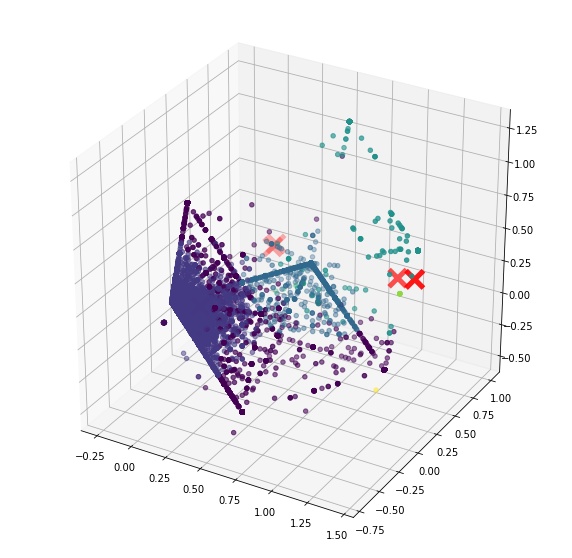

In [218]:
ax = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter(principalDf.iloc[:,0], principalDf.iloc[:,1], principalDf.iloc[:,2], marker='o',c=labels_ms)
ax.scatter(cluster_centers[:,0], cluster_centers[:,1], cluster_centers[:,2], marker='x', color='red', s=300, linewidth=5, zorder=10)


In [219]:
flag_aggregated['Cluster_MS'] = labels_ms
pd.DataFrame(flag_aggregated['Cluster_MS'].value_counts())

,Cluster_MS
0,31161
-1,4851
1,3647
2,210
3,10
4,6
5,1


In [223]:
orphans = per_agency_category.iloc[flag_aggregated[(flag_aggregated['cluster_DB'] == -1) & (flag_aggregated['Cluster_MS'] == -1)
                                        ].index,:]
orphans.head(20)

,Agency_Name,Merchant_Category,Year-Month,Amount_Mean_by_Month,Amount_Max_by_Month,Num_Transactions_by_Month,Amount_Mean_by_Merch,Num_Transactions_by_Merch,max_amount_ratio,mean_amount_ratio,mean_count_ratio
151,ATTORNEY GENERAL,DIRCT MARKETING/DIRCT MARKETERS--NOT ELSEWHERE...,201401,288.000000,356.00,2,460.406207,29,0.773230,0.625535,0.068966
193,ATTORNEY GENERAL,"GROCERY STORES,AND SUPERMARKETS",201307,45.780000,52.08,2,38.257000,10,1.361319,1.196644,0.200000
275,ATTORNEY GENERAL,MISCELLANEOUS PUBLISHING AND PRINTING SERVICES,201310,2189.590000,2840.54,2,898.825000,6,3.160281,2.436058,0.333333
548,BD. OF MED. LICENSURE & SUPV.,ELECTRICAL PARTS AND EQUIPMENT,201406,274.985000,300.00,2,535.942000,5,0.559762,0.513087,0.400000
2308,CORPORATION COMMISSION,STAYBRIDGE SUITES,201309,135.000000,405.00,3,223.200000,10,1.814516,0.604839,0.300000
2792,DEPARTMENT OF AGRICULTURE,CONTINUITY/SUBSCRIPTION MERCHANTS,201308,27.500000,35.00,2,41.062500,16,0.852359,0.669711,0.125000
3211,"DEPARTMENT OF AGRICULTURE, FOOD, ANF FOR",AMERICAN AIRLINES,201406,409.000000,570.50,4,426.089286,28,1.338921,0.959893,0.142857
3601,"DEPARTMENT OF AGRICULTURE, FOOD, ANF FOR",TRAVEL AGENCIES,201406,25.000000,25.00,5,25.000000,42,1.000000,1.000000,0.119048
3782,DEPARTMENT OF COMMERCE,ENTERPRISE RENT-A-CAR,201401,56.540000,169.62,3,140.045000,22,1.211182,0.403727,0.136364
3852,DEPARTMENT OF COMMERCE,HYATT HOTELS/INT'L,201309,271.475000,854.90,4,343.368889,27,2.489742,0.790622,0.148148


In [224]:
small_cluster = per_agency_category.iloc[flag_aggregated[(flag_aggregated['cluster_DB'] == 1) | (flag_aggregated['cluster_DB'] == 2) |
                                         (flag_aggregated['Cluster_MS'] == 3) |(flag_aggregated['Cluster_MS'] == 4) | 
                                         (flag_aggregated['Cluster_MS'] == 5)
                                        ].index,:]
small_cluster.head(20)

,Agency_Name,Merchant_Category,Year-Month,Amount_Mean_by_Month,Amount_Max_by_Month,Num_Transactions_by_Month,Amount_Mean_by_Merch,Num_Transactions_by_Merch,max_amount_ratio,mean_amount_ratio,mean_count_ratio
501,BD. OF MED. LICENSURE & SUPV.,BUSINESS SERVICES NOT ELSEWHERE CLASSIFIED,201311,113.050000,113.05,1,248.100741,27,0.455662,0.455662,0.037037
507,BD. OF MED. LICENSURE & SUPV.,BUSINESS SERVICES NOT ELSEWHERE CLASSIFIED,201406,257.170000,434.23,2,248.100741,27,1.750216,1.036555,0.074074
518,BD. OF MED. LICENSURE & SUPV.,CATERERS,201406,375.000000,375.00,1,416.803333,6,0.899705,0.899705,0.166667
521,BD. OF MED. LICENSURE & SUPV.,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS,201311,36.000000,36.00,1,245.428571,7,0.146682,0.146682,0.142857
537,BD. OF MED. LICENSURE & SUPV.,"COMPUTERS, COMPUTER PERIPHERAL EQUIPMENT, SOFT...",201406,790.740000,790.74,1,850.280000,7,0.929976,0.929976,0.142857
543,BD. OF MED. LICENSURE & SUPV.,"DURABLE GOODS, NOT ELSEWHERE CLASSIFIED",201311,55.920000,55.92,1,190.214000,5,0.293985,0.293985,0.200000
550,BD. OF MED. LICENSURE & SUPV.,ENTERPRISE RENT-A-CAR,201406,71.220000,71.22,1,149.985000,2,0.474847,0.474847,0.500000
555,BD. OF MED. LICENSURE & SUPV.,GOVERNMENT SERVICES--NOT ELSEWHERE CLASSIFIED,201311,47.376667,1411.43,33,28.647685,674,49.268553,1.653769,0.048961
562,BD. OF MED. LICENSURE & SUPV.,GOVERNMENT SERVICES--NOT ELSEWHERE CLASSIFIED,201406,58.690984,1649.95,61,28.647685,674,57.594531,2.048716,0.090504
570,BD. OF MED. LICENSURE & SUPV.,MEDICAL SERVICES & HEALTH PRACTITIONERS NOT EL...,201311,450.000000,450.00,1,450.000000,1,1.000000,1.000000,1.000000


###### Agencies to Look At

In [230]:
pd.concat([small_cluster[['Agency_Name','Merchant_Category']],orphans[['Agency_Name','Merchant_Category']]], axis=0).drop_duplicates().reset_index(drop=True)

,Agency_Name,Merchant_Category
0,BD. OF MED. LICENSURE & SUPV.,BUSINESS SERVICES NOT ELSEWHERE CLASSIFIED
1,BD. OF MED. LICENSURE & SUPV.,CATERERS
2,BD. OF MED. LICENSURE & SUPV.,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS
3,BD. OF MED. LICENSURE & SUPV.,"COMPUTERS, COMPUTER PERIPHERAL EQUIPMENT, SOFT..."
4,BD. OF MED. LICENSURE & SUPV.,"DURABLE GOODS, NOT ELSEWHERE CLASSIFIED"
5,BD. OF MED. LICENSURE & SUPV.,ENTERPRISE RENT-A-CAR
6,BD. OF MED. LICENSURE & SUPV.,GOVERNMENT SERVICES--NOT ELSEWHERE CLASSIFIED
7,BD. OF MED. LICENSURE & SUPV.,MEDICAL SERVICES & HEALTH PRACTITIONERS NOT EL...
8,BD. OF MED. LICENSURE & SUPV.,MISCELLANEOUS AND SPECIALTY RETAIL STORES
9,BD. OF MED. LICENSURE & SUPV.,"MOTOR FREIGHT CARRIERS,AND TRUCKING"


## Conclusion

Clustering is a very helpful technique when you encounter a unlabled dataset. Being able to group variables based on their chracteristics can help narrow down selection of observations to look at. In this case our cluster where able to pinpoint big outliers (orphans) and a group of Agency, Merchant combination with a lot of red flags. These observations need further analysis its the start for identifying true outliers.